In [1]:
#loading calib-object image
import cv2
import numpy as np
import glob
import os
import sys
import argparse
import json
import time
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from scipy.signal import convolve2d
from PIL import Image, ImageDraw


Q1: Own Calibration [4 points]
1. [1 point] For the given image calib-object.jpg, identify the chessboard internal corners. You may use external libraries to detect the chessboard corners. Note, each square of the chess board is 2cm × 2cm.

REPORT:
Problem: to obtain the chessboard corners for an L shaped image. 

Solution:
Applying an edge detection algorithm to get the edge space image of the given chessboard. Then using Harris corner detection, I found out the corners of the chessboard.  The algorithm was very succesful at providing the corner points of the image, with very few false positives.

The main challenges were to accurately calibrate the threshold value for supression of non maxima points and the K Value to be used as a scalar value in the formula.

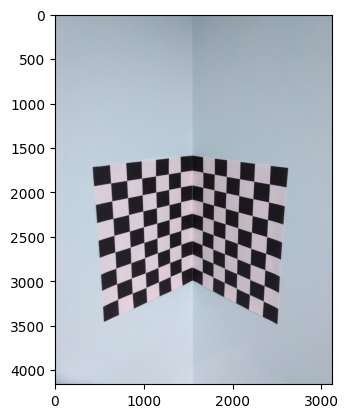

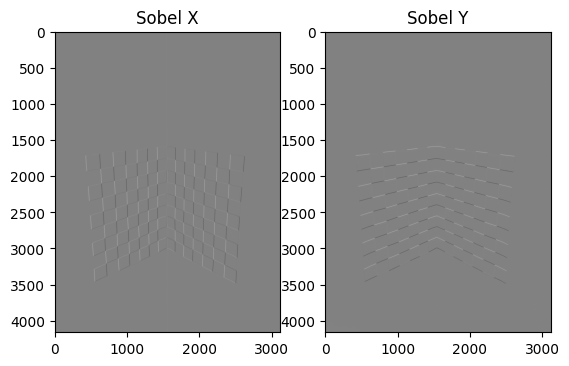

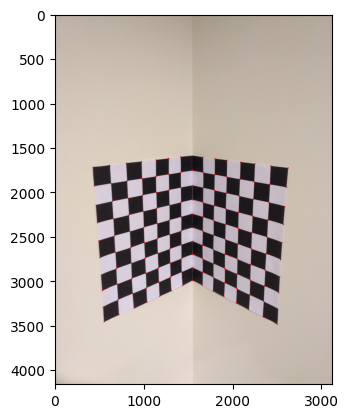

In [2]:
obj=cv2.imread('calib-object.jpg')
obj_g=cv2.cvtColor(obj,cv2.COLOR_BGR2GRAY)
chessboard_size = (7,9)


def sobel_filter(image):

    Gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Gy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    Ix = convolve2d(image, Gx, mode='same', boundary='symm')
    Iy = convolve2d(image, Gy, mode='same', boundary='symm')
    
    return Ix, Iy

def harris_corner_detection(Ix, Iy, k=0.1, threshold=0.1):

    Ixx = Ix**2
    Iyy = Iy**2
    Ixy = Ix*Iy
    window = np.ones((5, 5))
    #using a gaussian filter
    # window = np.array([[1, 4, 6, 4, 1],
    #                    [4, 16, 24, 16, 4],
    #                    [6, 24, 36, 24, 6],
    #                    [4, 16, 24, 16, 4],
    #                    [1, 4, 6, 4, 1]]) / 256
    sum_Ixx = convolve2d(Ixx, window, mode='same')
    sum_Iyy = convolve2d(Iyy, window, mode='same')
    sum_Ixy = convolve2d(Ixy, window, mode='same')
    det_M = sum_Ixx * sum_Iyy - sum_Ixy**2
    trace_M = sum_Ixx + sum_Iyy
    R = det_M - k * (trace_M**2)
    corners = R > threshold * R.max()
    corner_coords = np.argwhere(corners)
    return corners,corner_coords

Ix, Iy = sobel_filter(obj_g)

plt.imshow(obj)
plt.show()


plt.figure()
plt.subplot(1,2,1)
plt.imshow(Ix,cmap='gray')
plt.title('Sobel X')
plt.subplot(1,2,2)
plt.imshow(Iy,cmap='gray')
plt.title('Sobel Y')
plt.show()

corners,x_img = harris_corner_detection(Ix, Iy)

def plot_corners_on_image(image_path, corners):
  
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)
    corner_radius = 5
    corner_color = 'red'
    
    for y in range(corners.shape[0]):
        for x in range(corners.shape[1]):
            if corners[y, x]: 
                left_up_point = (x - corner_radius, y - corner_radius)
                right_down_point = (x + corner_radius, y + corner_radius)
                draw.ellipse([left_up_point, right_down_point], fill=corner_color)
    
    plt.imshow(img)
    plt.show()
    img.save('image_with_corners.jpg')

plot_corners_on_image('calib-object.jpg', corners)


In [3]:
# #increasing the contrast of the image to check if it possibly gives better edge detection

# def increase_contrast(image):
    
#     contrast_stretched = np.zeros_like(image)
    
#     for c in range(3): 
#         min_val = np.min(image[:, :, c])
#         max_val = np.max(image[:, :, c])
        
#         contrast_stretched[:, :, c] = (image[:, :, c] - min_val) / (max_val - min_val) * 255
        
#     return contrast_stretched.astype(np.uint8)

# obj1=increase_contrast(obj)
# obj1_g=cv2.cvtColor(obj1,cv2.COLOR_BGR2GRAY)

# Ix1, Iy1=sobel_filter(obj1_g)

# plt.imshow(obj1)
# plt.show()

# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(Ix1,cmap='gray')
# plt.title('Sobel X')
# plt.subplot(1,2,2)
# plt.imshow(Iy1,cmap='gray')
# plt.title('Sobel Y')
# plt.show()

# corners1 = harris_corner_detection(Ix1, Iy1)

# plot_corners_on_image('calib-object.jpg', corners1)

#The contrast increase does not effect the edge detection at all since it is a gradient based approach



2. [1.5 points] Implement the camera calibration process discussed in the lecture. Assume a world origin, create a set of corresponding points in the world coordinate and image plane, compute both extrinsics (translation vector, rotation matrix) and intrinsics (assume no skew) without using any external libraries for the calib-object.jpg image.

 Zhengyou Zhang in his 2000 paper titled "A Flexible New Technique for Camera Calibration" proposed a method which revolutionized camera calibration by offering a flexible, efficient, and easy-to-implement approach that requires only a planar pattern (like a chessboard) viewed at a few (at least two) different orientations. I would be implementing the same calibration for this chess board image as it has two views in a single image, hence making it easier for estimating the camera intrinsic parameters.

Homography between Planar Pattern and Image
$$s \begin{bmatrix} u_i \\ v_i \\ 1 \end{bmatrix} = H \begin{bmatrix} X_i \\ Y_i \\ 1 \end{bmatrix}
$$
Decomposition of Homography
$$
H = \lambda K [R | t]
$$
Where K is the intrinsic matrix:
$$
K = \begin{bmatrix} \alpha & \gamma & u_0 \\ 0 & \beta & v_0 \\ 0 & 0 & 1 \end{bmatrix}
$$
Solving for intrinsic parameters using multiple homographies:
$$h_{1}^{T} K^{-T} K^{-1} h_{2} = 0 $$
$$h_{1}^{T} K^{-T} K^{-1} h_{1} = h_{2}^{T} K^{-T} K^{-1} h_{2}
$$
Computing extrinsic parameters from the homography:
$$r_1 = \lambda K^{-1} h_1$$
$$r_2 = \lambda K^{-1} h_2$$
$$r_3 = r_1 \times r_2$$
$$t = \lambda K^{-1} h_3$$
Minimizing the reprojection error:
$$
\min \sum_{i=1}^{n} \sum_{j=1}^{m} \| p_{ij} - \hat{p}_{ij}(K, R_j, t_j) \|^2
$$

In [4]:
def homography(correspondences):
    A = []
    for X, x in correspondences:
        # Correctly set up the rows based on the homography equation
        A.append([X[0], X[1], 1, 0, 0, 0, -x[0]*X[0], -x[0]*X[1], -x[0]])
        A.append([0, 0, 0, X[0], X[1], 1, -x[1]*X[0], -x[1]*X[1], -x[1]])
    A = np.array(A)
    U, S, V = np.linalg.svd(A)
    H = V[-1,:].reshape(3, 3)  # Normalize the last row of V to get H
    return H

world_points = np.array([[14, 0, 0],
                         [8, 0, 0],
                         [14, -6, 0],
                         [10, -12, 0],
                         [8, -6, 0],
                         [4, -18, 0],
                         [2, -12, 0],
                         [0, 0, 0],
                         [0, 0, -8],
                         [0, 0, -14],
                         [0, -6, 0],
                         [0, -6, -8],
                         [0, -6, -14],
                         [0, -12, -8],
                         [0, -18, -14],
                         [0, -18, 0]])

image_points = np.array([[422, 1716], 
                         [968, 1649], 
                         [473, 2348],
                         [858, 2790],
                         [990, 2219],
                         [1305, 3112],
                         [1423, 2582],
                         [1545, 1587], 
                         [2079, 1659], 
                         [2612, 1724],
                         [1533, 2084],
                         [2060, 2228],
                         [2562, 2366],
                         [1909, 2698],
                         [2487, 3474],
                         [1542, 2994]])


world_points_homogeneous = np.hstack((world_points, np.ones((world_points.shape[0], 1))))
image_points_homogeneous = np.hstack((image_points, np.ones((image_points.shape[0], 1))))
    
correspondences = [(world_points_homogeneous[i][:2], image_points_homogeneous[i]) for i in range(len(world_points_homogeneous))]

# Now, run the corrected homography calculation
H = homography(correspondences)
def extract_elements_V(H):
    # Construct the elements of V as shown
    v12 = np.array([
        H[0, 0]*H[0, 1],
        H[0, 0]*H[1, 1] + H[1, 0]*H[0, 1],
        H[1, 0]*H[1, 1],
        H[2, 0]*H[0, 1] + H[0, 0]*H[2, 1],
        H[2, 0]*H[1, 1] + H[1, 0]*H[2, 1],
        H[2, 0]*H[2, 1]
    ])
    
    v11 = np.array([
        H[0, 0]*H[0, 0],
        H[0, 0]*H[1, 0] + H[1, 0]*H[0, 0],
        H[1, 0]*H[1, 0],
        H[2, 0]*H[0, 0] + H[0, 0]*H[2, 0],
        H[2, 0]*H[1, 0] + H[1, 0]*H[2, 0],
        H[2, 0]*H[2, 0]
    ])
    
    v22 = np.array([
        H[0, 1]*H[0, 1],
        H[0, 1]*H[1, 1] + H[1, 1]*H[0, 1],
        H[1, 1]*H[1, 1],
        H[2, 1]*H[0, 1] + H[0, 1]*H[2, 1],
        H[2, 1]*H[1, 1] + H[1, 1]*H[2, 1],
        H[2, 1]*H[2, 1]
    ])
    V = np.vstack((v12, v11 - v22))
    
    return V


# Now, let's proceed with the V matrix extraction, SVD, and calculation of B
V = extract_elements_V(H)
U, S, Vt = np.linalg.svd(V)
b = Vt[-1, :]
B = np.array([
    [b[0], b[1], b[3]],
    [b[1], b[2], b[4]],
    [b[3], b[4], b[5]]
])

print("B Matrix:", B)

eigenvalues, eigenvectors = np.linalg.eig(B)
enforced_eigenvalues = np.clip(eigenvalues, a_min=1e-6, a_max=None)
enforced_B = eigenvectors @ np.diag(enforced_eigenvalues) @ eigenvectors.T

# Attempting Cholesky decomposition on the enforced B
try:
    K = np.linalg.cholesky(enforced_B).T  
    print("Intrinsic Matrix:", K)
except np.linalg.LinAlgError as e:
    print("Error in Cholesky decomposition:", e)


K_inv = np.linalg.inv(K)
H = K_inv @ H
H = H / H[2, 2]
r1 = H[:, 0]
r2 = H[:, 1]
r3 = np.cross(r1, r2)
t = H[:, 2]
r1 = r1 / np.linalg.norm(r1)
r2 = r2 / np.linalg.norm(r2)
r3 = r3 / np.linalg.norm(r3)
t = t / np.linalg.norm(t)
R = np.vstack((r1, r2, r3)).T
t = t.reshape(3, 1)
print("Extrinsic Matrix R:", R)
print("Extrinsic Matrix t:", t)

# Now, let's calculate the final extrinsic matrix
extrinsic_matrix = np.hstack((R, t))
print("Extrinsic Matrix:", extrinsic_matrix)

# Now, let's calculate the final projection matrix
projection_matrix = K @ extrinsic_matrix
print("Projection Matrix:", projection_matrix)

P_norm=projection_matrix/projection_matrix[2,3]


B Matrix: [[ 1.45430326e-06 -2.34797784e-06 -1.66273713e-08]
 [-2.34797784e-06 -3.88639748e-07 -5.50231879e-09]
 [-1.66273713e-08 -5.50231879e-09  1.00000000e+00]]
Intrinsic Matrix: [[ 1.55015427e-03 -6.17067792e-04 -1.07262536e-05]
 [ 0.00000000e+00  1.12756512e-03 -1.07498093e-05]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Extrinsic Matrix R: [[-9.42211798e-01  9.32903010e-01 -4.79776445e-06]
 [-3.35017802e-01  3.60127720e-01  1.40499212e-05]
 [-1.86463449e-07  5.83917190e-07 -1.00000000e+00]]
Extrinsic Matrix t: [[7.73104732e-01]
 [6.34278388e-01]
 [3.88663493e-07]]
Extrinsic Matrix: [[-9.42211798e-01  9.32903010e-01 -4.79776445e-06  7.73104732e-01]
 [-3.35017802e-01  3.60127720e-01  1.40499212e-05  6.34278388e-01]
 [-1.86463449e-07  5.83917190e-07 -1.00000000e+00  3.88663493e-07]]
Projection Matrix: [[-1.25384495e-03  1.22392036e-03  1.07101466e-05  8.07038835e-04]
 [-3.77754387e-04  4.06067451e-04  1.07656515e-05  7.15190184e-04]
 [-1.86463449e-07  5.83917190e-07 -1.00000

3. [1 point] Use the real-world measurements along with the estimated camera parameters to compute the image of a wireframe of the object (Hint: the wireframe is the outer corners of the actual chessboard pattern and has 6 points). Note that you should compute the location of image points as xi = PXi, where P is the projection matrix computed above. Overlay (draw) the wireframe over the actual image of the object using straight lines between the computed points xi. What do you observe about the overlay?

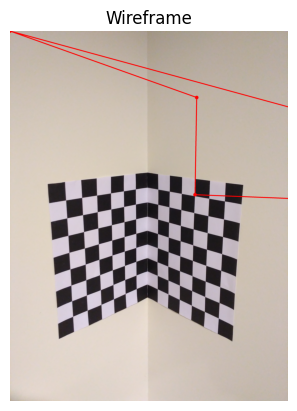

In [5]:
wireframe_world_points = np.array([[0, 0, 0], [14, 0, 0], [14, 0, 18], [0, 0, 18], [0, 14, 18], [0, 14, 0]])
wireframe_world_points_homogeneous = np.hstack((wireframe_world_points, np.ones((wireframe_world_points.shape[0], 1)))) 


radius = 20
for i in range(len(wireframe_world_points)):
    point = P_norm @ wireframe_world_points_homogeneous[i]
    point = point / point[2]
    cv2.circle(obj, (int(point[0]), int(point[1])), radius, (0, 0, 255), -1)

    if i < len(wireframe_world_points) - 1:
        next_point = P_norm@ wireframe_world_points_homogeneous[i + 1]
        next_point = next_point / next_point[2]
        cv2.line(obj, (int(point[0]), int(point[1])), (int(next_point[0]), int(next_point[1])), (0, 0,2550), 10)

next_point = P_norm@ wireframe_world_points_homogeneous[0]
next_point = next_point / next_point[2]
cv2.line(obj, (int(point[0]), int(point[1])), (int(next_point[0]), int(next_point[1])), (0, 0,2550), 10)

plt.imshow(cv2.cvtColor(obj, cv2.COLOR_BGR2RGB))
plt.title('Wireframe')
plt.axis('off')

plt.show()

In [9]:
import numpy as np
from scipy.linalg import rq

pts_world = np.array([[0, 14, 0], [0, 8, 0], [0, 14, 6], [0, 10, 12], [0, 8, 6], [0, 4, 18],
                      [0, 2, 12], [0, 0, 0], [8, 0, 0], [14, 0, 0], [0, 0, 6], [8, 0, 6],
                      [14, 0, 6], [8, 0, 12], [14, 0, 18], [0, 0, 18]])
pts_image = np.array([[422, 1716], [968, 1649], [473, 2348], [858, 2790], [990, 2219], [1305, 3112],
                      [1423, 2582], [1545, 1587], [2079, 1659], [2612, 1724], [1533, 2084], [2060, 2228],
                      [2562, 2366], [1909, 2698], [2487, 3474], [1542, 2994]])

homogeneous_world = np.concatenate((pts_world, np.ones((pts_world.shape[0], 1))), axis=1)
homogeneous_image = np.concatenate((pts_image, np.ones((pts_image.shape[0], 1))), axis=1)

matrix_A = np.zeros((2 * pts_world.shape[0], 12))
for idx, (world, image) in enumerate(zip(homogeneous_world, homogeneous_image)):
    X, Y, Z, _ = world
    u, v, _ = image
    matrix_A[2 * idx] = [X, Y, Z, 1, 0, 0, 0, 0, -u * X, -u * Y, -u * Z, -u]
    matrix_A[2 * idx + 1] = [0, 0, 0, 0, X, Y, Z, 1, -v * X, -v * Y, -v * Z, -v]

ATA = matrix_A.T.dot(matrix_A)
eig_vals, eig_vecs = np.linalg.eig(ATA)
min_eig_val_idx = np.argmin(eig_vals)
P = eig_vecs[:, min_eig_val_idx].reshape(3, 4)

P_normalized =P/ P[2, 3]

K, R1 = rq(P_normalized[:, :3])
K /= K[2, 2]
T = np.linalg.inv(K).dot(P_normalized[:, 3])

K, R1, T, P_normalized




(array([[-3.12980639e+03, -5.22750328e+01,  1.59719575e+03],
        [-0.00000000e+00,  3.18521386e+03,  1.94179581e+03],
        [-0.00000000e+00, -0.00000000e+00,  1.00000000e+00]]),
 array([[ 0.70113856, -0.71302091,  0.00242713],
        [-0.14151019, -0.14248661, -0.97962872],
        [ 0.6988416 ,  0.68651201, -0.20080258]]),
 array([ 0.01990572, -0.10667201,  1.        ]),
 array([[ 2.80208061e+01, -8.72817214e+01,  7.25107795e+00,
          1.54047100e+03],
        [-2.37143349e+01, -2.30064733e+01,  9.18527002e+01,
          1.60202264e+03],
        [-1.82866140e-02, -1.79639853e-02,  5.25440850e-03,
          1.00000000e+00]]))

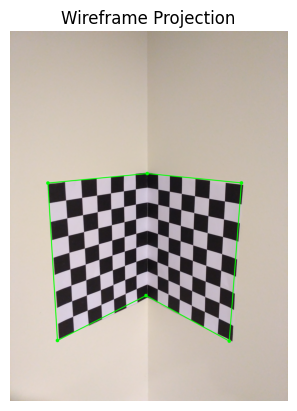

In [7]:


wireframe_points = np.array([
    [0, 0, 0],
    [14, 0, 0],
    [14, 0, 18],
    [0, 0, 18],
    [0, 14, 18],
    [0, 14, 0]
])
homogeneous_wireframe_points = np.hstack((wireframe_points, np.ones((wireframe_points.shape[0], 1))))


original_image = cv2.imread('calib-object.jpg')
annotated_image = original_image.copy()


circle_radius = 20
line_thickness = 10
color_red = (0, 255, 0) 


for i, point in enumerate(homogeneous_wireframe_points):
    projected_point = P_normalized @ point
    projected_point /= projected_point[2]  

  
    cv2.circle(annotated_image, (int(projected_point[0]), int(projected_point[1])), circle_radius, color_red, -1)

    if i < len(homogeneous_wireframe_points) - 1:
        next_point = homogeneous_wireframe_points[i + 1]
    else:
        next_point = homogeneous_wireframe_points[0] 
   
    projected_next_point = P_normalized @ next_point
    projected_next_point /= projected_next_point[2]

    cv2.line(annotated_image, (int(projected_point[0]), int(projected_point[1])), 
             (int(projected_next_point[0]), int(projected_next_point[1])), color_red, line_thickness)


plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.title('Wireframe Projection')
plt.axis('off')
plt.show()


Report:
The problem was to perform camera calibration from scratch and overlay a wireframe on top of it.

Solution:
So the calculation was carried out in two ways- one was through zhang's method and the other way was to recover the K, R and T matrices performing simple linear algebra steps.

Challenges:
accurately annotating the imagepoints and world points
trying out diffrent methods
getting the accurate value of K matrix, because there were few calculation mistakes

4. [0.5 points] Given the rotation matrix, compute the three rotation angles. Explain the values that you obtain in terms of pan, tilt, and roll?


In [10]:
beta = np.arcsin(-R1[0, 2])
alpha = np.arctan2(R1[1, 2], R[2, 2])
gamma = np.arctan2(R1[0, 1], R[0, 0])

beta_degrees = np.degrees(beta)
alpha_degrees = np.degrees(alpha)
gamma_degrees = np.degrees(gamma)

print("Rotation Angles:")
print(f"Pan (alpha): {alpha_degrees} degrees")
print(f"Tilt (beta): {beta_degrees} degrees")
print(f"Roll (gamma): {gamma_degrees} degrees")


Rotation Angles:
Pan (alpha): -101.58393012021394 degrees
Tilt (beta): -0.13906423892640427 degrees
Roll (gamma): -45.48141139234373 degrees


Q2:
OpenCV Calibration [3 points]
1. [1.5 points] Now repeat the camera calibration process for calib-object.jpg using OpenCV calibration func- tions, continue to assume that there is no skew or distortion (Hint: see calibrateCamera() FLAGS). How does your result compare with Q1 above? Repeat the overlay of the wireframe using the new parameters. Describe your observations.


Both wireframes are pretty similar to each other, though the manual one is a little better. This is due to the rough estimate that was provided to OpenCV calibrate function since it only calibrates planar objects. 

In [11]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def read_and_convert_image(path):
    img = cv2.imread(path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img, img_gray

def find_chessboard_corners(gray_img, pattern_size):
    return cv2.findChessboardCorners(gray_img, pattern_size, None)

def draw_chessboard_corners(img, pattern_size, corners, ret):
    cv2.drawChessboardCorners(img, pattern_size, corners, ret)
    return img

def generate_object_points(pattern_size, square_size):
    objp = np.zeros((np.prod(pattern_size), 3), np.float32)
    objp[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)
    objp *= square_size
    return objp

def calibrate_camera(object_points, image_points, img_shape):
    return cv2.calibrateCamera([object_points], [image_points], img_shape, None, None)

def compute_projection_matrix(camera_matrix, rvecs, tvecs):
    rotation_matrix, _ = cv2.Rodrigues(rvecs[0])
    extrinsics = np.hstack((rotation_matrix, tvecs[0]))
    return camera_matrix @ extrinsics

def project_points(points_3d, camera_matrix, rvecs, tvecs, dist_coeffs):
    return cv2.projectPoints(points_3d, rvecs, tvecs, camera_matrix, dist_coeffs)[0].reshape(-1, 2)

def draw_projection(img, points_2d, color=(0, 255,0), radius=10, thickness=-1):
    for point in points_2d:
        cv2.circle(img, tuple(point.astype(int)), radius, color, thickness)
    return img

def draw_lines(img, points_2d, color=(0, 255,0 ), thickness=5):
    num_points = len(points_2d)
    for i in range(num_points):
        pt1 = tuple(points_2d[i].astype(int))
        pt2 = tuple(points_2d[(i + 1) % num_points].astype(int))
        cv2.line(img, pt1, pt2, color, thickness)
    return img


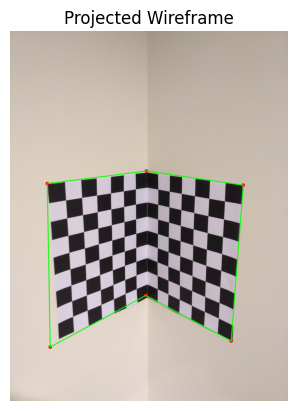

In [12]:

import numpy as np
import cv2
from matplotlib import pyplot as plt


path_img = 'calib-object.jpg'
img, img_gray = read_and_convert_image(path_img)


world_points = np.array([
    [14, 0, 0], [8, 0, 0], [14, -6, 0], [10, -12, 0], [8, -6, 0], [4, -18, 0],
    [2, -12, 0], [0, 0, 0], [0, 0, -8], [0, 0, -14], [0, -6, 0], [0, -6, -8],
    [0, -6, -14], [0, -12, -8], [0, -18, -14], [0, -18, 0]
], dtype=np.float32)

image_points = np.array([
    [422, 1716], [968, 1649], [473, 2348], [858, 2790], [990, 2219], [1305, 3112],
    [1423, 2582], [1545, 1587], [2079, 1659], [2612, 1724], [1533, 2084], [2060, 2228],
    [2562, 2366], [1909, 2698], [2487, 3474], [1542, 2994]
], dtype=np.float32)

focal_length = img_gray.shape[1]  
center = (img_gray.shape[1] / 2, img_gray.shape[0] / 2)  


mtx_init = np.array([
    [focal_length, 0, center[0]],
    [0, focal_length, center[1]],
    [0, 0, 1]
], dtype="double")


ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objectPoints=[world_points], 
    imagePoints=[image_points], 
    imageSize=(img_gray.shape[1], img_gray.shape[0]), 
    cameraMatrix=mtx_init, 
    distCoeffs=None, 
    flags=cv2.CALIB_USE_INTRINSIC_GUESS  
)


rotation_matrix, _ = cv2.Rodrigues(rvecs[0])
translation_vector = tvecs[0]
extrinsics = np.hstack((rotation_matrix, translation_vector))
projection_matrix = mtx @ extrinsics


wireframe_world_points = np.array([
    [0, 0, 0], [0, 0, -14], [0, -18, -14], [0, -18, 0], [14, -18, 0], [14, 0, 0], [0, 0, 0]  # Closing the loop
], dtype=np.float32)


projected_points_2d = project_points(wireframe_world_points, mtx, rvecs[0], tvecs[0], dist)
dst_img = img.copy()
dst_img = draw_projection(dst_img, projected_points_2d, (0, 0, 255), 20)  # Draw points
dst_img = draw_lines(dst_img, projected_points_2d, (0, 255, 0), 10)  # Draw lines in green for clarity

# Display the result
plt.imshow(cv2.cvtColor(dst_img, cv2.COLOR_BGR2RGB))
plt.title('Projected Wireframe')
plt.axis('off')
plt.show()


2. [1 point] Repeat Q2.1, for the second image assign1.jpg. Does the wireframe overlay show significant distor- tions? Comment. What can we say about the computed projection matrix when trying to do calibration based on world coordinate points that are co-planar? (Hint: we looked at co-planar points in two-view geometry).


The wireframe was better than the previous example since the points are coplanar in this case an d do not require an additional estimate of K to calibrate around.

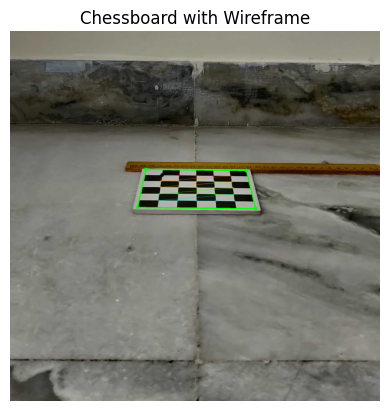

In [13]:


path_img = './assign1.jpg'
pattern_size = (5, 5)
square_size = 2

img, img_gray = read_and_convert_image(path_img)
ret, corners = find_chessboard_corners(img_gray, pattern_size)

if ret:
    img = draw_chessboard_corners(img, pattern_size, corners, ret)
    object_points = generate_object_points(pattern_size, square_size)
    corners = cv2.cornerSubPix(img_gray, corners, (11, 11), (-1, -1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
    ret, mtx, dist, rvecs, tvecs = calibrate_camera(object_points, corners, img_gray.shape[::-1])
    projection_matrix = compute_projection_matrix(mtx, rvecs, tvecs)
    
    # Define points to project
    points_3d = np.array([[-2, -2, 0], [10, -2, 0], [10, 10, 0], [-2, 10, 0]], dtype=np.float32)
    points_2d = project_points(points_3d, mtx, rvecs[0], tvecs[0], dist)
    
    img = draw_projection(img, points_2d)
    img = draw_lines(img, points_2d)
    origin_2d = project_points(np.array([[0, 0, 0]], dtype=np.float32), mtx, rvecs[0], tvecs[0], dist)
    img = draw_projection(img, origin_2d,  20)
    
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Chessboard with Wireframe')
    plt.axis('off')
    plt.show()


3. [0.5 points] What is the image of the world origin, given the calibration matrix? Does this result agree with your observations?

The origin is marked in the above image with the black dot. This observation is consistent with the origin that was defined, since opencv returns only internal corners of the chessboard, the first internal corner at top left was defined to be the origin.

Q3: Moving the Chessboard [3 points]
1. [1.5 points] Imagine that the chessboard in assign1.jpg was moved by 10 cm to the right (along the ruler). Overlay a wireframe (4 points) of the virtual chessboard on the image at the appropriate location. Does the wireframe look consistent with what you expect?

Yes, it is consistent with what I expected as from the projection matrix itself, it is pretty evident that the angles will not be preserved and hence the edges don't scale well when linearly translated along the ruler.

Challenges:
Correct positioning of points, projection and estimating how the chessboard would move in the image.

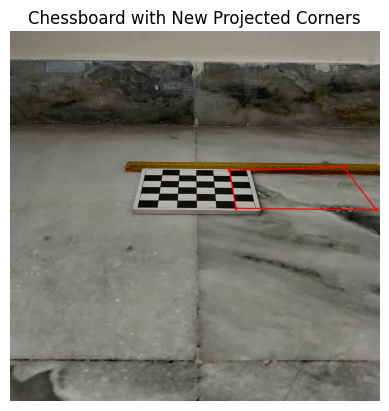

In [14]:

path_img = './assign1.jpg'
img, img_gray = read_and_convert_image(path_img)

corner_coordinates = np.array([[8, -2, 0], [20, -2, 0], [20, 10, 0], [8, 10, 0]], dtype=np.float32)

projected_corner_coordinates = project_points(corner_coordinates, mtx, rvecs[0], tvecs[0], dist)

img = draw_projection(img, projected_corner_coordinates, (0, 0, 255), 10, -1)
img = draw_lines(img, projected_corner_coordinates, (0, 0, 255), 5)


plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Chessboard with New Projected Corners')
plt.axis('off')
plt.show()


2. [1.5 points] Now, think of how you would move the actual pixels or pattern of the chessboard? Overlay the chessboard pattern within the predicted wireframe. Is the overlay consistent with what you expect?

Given that we were given only one image, and the projection matrix was based off that clculation solely, the ouput is expected to be a little distorted. This is pretty common occurence in manual calibration. Gnerally a set of images is taken to minimise the error in projection by posing it as an optimization problem. 

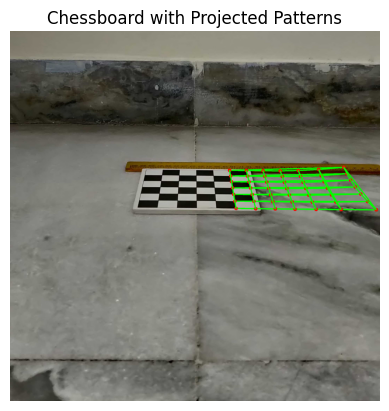

In [15]:
path_img = './assign1.jpg'
img, img_gray = read_and_convert_image(path_img)


corner_sets = [
    np.array([[8, -2, 0], [10, -2, 0], [12, -2, 0], [14, -2, 0], [16, -2, 0], [18, -2, 0], [20, -2, 0], [20, 0, 0], [20, 2, 0], [20, 4, 0], [20, 6, 0], [20, 8, 0], [20, 10, 0], [18, 10, 0], [16, 10, 0], [14, 10, 0], [12, 10, 0], [10, 10, 0], [8, 10, 0], [8, 8, 0], [8, 6, 0], [8, 4, 0], [8, 2, 0], [8, 0, 0]], dtype=np.float32),
    np.array([[10, 0, 0], [12, 0, 0], [14, 0, 0], [16, 0, 0], [18, 0, 0], [18, 2, 0], [18, 4, 0], [18, 6, 0], [18, 8, 0], [16, 8, 0], [14, 8, 0], [12, 8, 0], [10, 8, 0], [10, 6, 0], [10, 4, 0], [10, 2, 0]], dtype=np.float32),
    np.array([[12, 2, 0], [14, 2, 0], [16, 2, 0], [16, 4, 0], [16, 6, 0], [14, 6, 0], [12, 6, 0], [12, 4, 0]], dtype=np.float32)
]

for i in range(-2, 12, 2):
    corner_sets.append(np.array([[8, i, 0], [10, i, 0], [12, i, 0], [14, i, 0], [16, i, 0], [18, i, 0], [20, i, 0]], dtype=np.float32))

for i in range(8, 22, 2):
    corner_sets.append(np.array([[i, -2, 0], [i, 0, 0], [i, 2, 0], [i, 4, 0], [i, 6, 0], [i, 8, 0], [i, 10, 0]], dtype=np.float32))

for corners in corner_sets:
    projected_corners = project_points(corners, mtx, rvecs[0], tvecs[0], dist)
    img = draw_projection(img, projected_corners, (0, 0, 255), 10, -1)  # Draw points
    img = draw_lines(img, np.append(projected_corners, [projected_corners[0]], axis=0), (0, 255, 0), 5)  # Draw lines with closure

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Chessboard with Projected Patterns')
plt.axis('off')
plt.show()
